In [2]:
import sys
sys.path.insert(0, '..')

In [3]:
import os
import copy
import json
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from tqdm import tqdm
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from utils.crowd.synthetic_data import generate_random_conf_matrix, generate_dl_conf_matrix, generate_box_parameters, generate_synthetic_data, crowd_labels2df, crowd_labels_df2txt
from models.rpn_generator import RPNGenerator

In [4]:
val_coco = COCO('../.data/MSCOCO/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


In [5]:
val_coco.imgToAnns[397133][0]

{'segmentation': [[224.24,
   297.18,
   228.29,
   297.18,
   234.91,
   298.29,
   243.0,
   297.55,
   249.25,
   296.45,
   252.19,
   294.98,
   256.61,
   292.4,
   254.4,
   264.08,
   251.83,
   262.61,
   241.53,
   260.04,
   235.27,
   259.67,
   230.49,
   259.67,
   233.44,
   255.25,
   237.48,
   250.47,
   237.85,
   243.85,
   237.11,
   240.54,
   234.17,
   242.01,
   228.65,
   249.37,
   224.24,
   255.62,
   220.93,
   262.61,
   218.36,
   267.39,
   217.62,
   268.5,
   218.72,
   295.71,
   225.34,
   297.55]],
 'area': 1481.3806499999994,
 'iscrowd': 0,
 'image_id': 397133,
 'bbox': [217.62, 240.54, 38.99, 57.75],
 'category_id': 44,
 'id': 82445}

In [6]:
[(x['bbox'], x['category_id']) for x in val_coco.imgToAnns[397133]]

[([217.62, 240.54, 38.99, 57.75], 44),
 ([1.0, 240.24, 346.63, 186.76], 67),
 ([388.66, 69.92, 109.41, 277.62], 1),
 ([135.57, 249.43, 22.32, 28.79], 49),
 ([31.28, 344.0, 68.12, 40.83], 51),
 ([59.63, 287.36, 76.07, 41.3], 51),
 ([1.36, 164.33, 192.56, 98.37], 79),
 ([0.0, 262.81, 62.16, 36.77], 1),
 ([119.4, 272.51, 24.82, 34.25], 47),
 ([141.47, 267.91, 32.19, 35.86], 47),
 ([155.97, 168.95, 26.03, 17.13], 51),
 ([157.2, 114.15, 17.86, 15.82], 51),
 ([98.75, 304.78, 10.78, 5.57], 56),
 ([166.03, 256.36, 8.82, 18.58], 50),
 ([86.41, 293.97, 23.96, 11.18], 56),
 ([70.14, 296.16, 9.28, 4.58], 56),
 ([0.0, 210.9, 191.36, 98.98], 79),
 ([96.69, 297.09, 7.84, 4.86], 57),
 ([497.25, 203.4, 122.01, 28.61], 81)]

In [7]:
class COCODataset():
    def __init__(self, ann_file, img_dir='../.data/MSCOCO/images'):
        self.coco = COCO(ann_file)
        self.classes = ['background']
        self.superclasses = ['background']
        for i in range(1, max(self.coco.cats.keys()) + 1):
            if i not in self.coco.cats:
                continue
            self.classes.append(self.coco.cats[i]['name'])
            self.superclasses.append(self.coco.cats[i]['supercategory'])
        self.images, self.gt = [], []
        for img_id, img_dict in self.coco.imgs.items():
            self.images.append(os.path.join(img_dir, img_dict['file_name']))
            final_anns = []
            for ann in self.coco.imgToAnns[img_id]:
                if ann['bbox'][2] <= 1 or ann['bbox'][3] <= 1:
                    continue
                if 'iscrowd' in ann:
                    if ann['iscrowd'] == 1:
                        continue
                final_anns.append(self.xywh2xyxy(ann['bbox']) + [self.classes.index(self.coco.cats[ann['category_id']]['name'])])
            if len(final_anns):
                self.gt.append(np.asarray(final_anns).astype(int).tolist())
            else:
                self.gt.append(np.zeros((0, 5), dtype=int))
        
        self.related_classes = []
        for cls_id in range(len(self.classes)):
            related_indices = [i for i, x in enumerate(self.superclasses) if x == self.superclasses[cls_id] and i != cls_id]
            self.related_classes.append(related_indices)
        
    def xywh2xyxy(self, x):
        y = copy.deepcopy(x)
        y[2] = x[0] + x[2]
        y[3] = x[1] + x[3]
        return y
    
    def get_gt(self, index: int):        
        return self.gt[index]
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB") 
        return img, self.get_gt(index)
    
    def __len__(self):
        return len(self.images)

In [8]:
train_dataset = COCODataset('../.data/MSCOCO/annotations/instances_train2017.json')
test_dataset = COCODataset('../.data/MSCOCO/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=11.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [9]:
import cv2
import matplotlib.pyplot as plt
import bbox_visualizer as bbv

#visualization

(-0.5, 639.5, 426.5, -0.5)

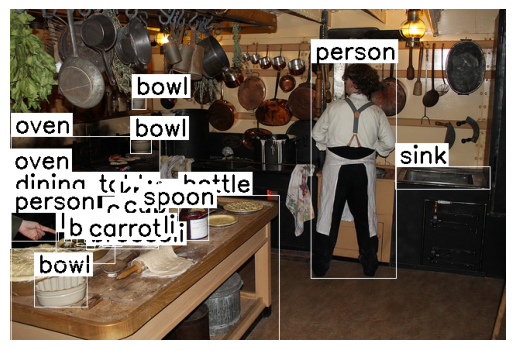

In [10]:
i = 0
img_path = test_dataset.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

bboxes = [x[:4] for x in test_dataset.get_gt(i)]
labels = [test_dataset.classes[x[4]] for x in test_dataset.get_gt(i)]
for box, label in zip(bboxes, labels):
    img = bbv.draw_rectangle(img, box, thickness=1)
    img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
# crowd_labels[i]

In [11]:
print(train_dataset.classes), len(train_dataset.classes)

['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


(None, 81)

In [12]:
missing_train = [train_dataset.images[i] for i, x in enumerate(train_dataset.gt) if len(x) == 0] # coco has missing annotation for 1k image
missing_test = [test_dataset.images[i] for i, x in enumerate(test_dataset.gt) if len(x) == 0]
len(missing_train), len(missing_test)

(1021, 48)

In [12]:
alexnet_cm = np.load('../outputs/classification-coco/alexnet_scratch/conf_matrix.npy') + 1
vgg16_cm = np.load('../outputs/classification-coco/vgg16_scratch/conf_matrix.npy') + 1
resnet50_cm = np.load('../outputs/classification-coco/resnet50_scratch/conf_matrix.npy') + 1

In [13]:
dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=False, batch_size=16, collate_fn=lambda x: x)
device = torch.device('cuda')

In [14]:
# rpn proposals
resnet18_weight = '../outputs/rpn-coco/resnet18/weights/epoch_004.pt'
resnet50_weight = '../outputs/rpn-coco/resnet50/weights/epoch_004.pt'
resnet101_weight = '../outputs/rpn-coco/resnet101/weights/epoch_004.pt'


if os.path.exists('./coco_proposals_cache.pickle'):
    with open('./coco_proposals_cache.pickle', 'rb') as f:
        proposals = pickle.load(f)
        resnet18_proposals = proposals['resnet18']
        resnet50_proposals = proposals['resnet50']
        resnet101_proposals = proposals['resnet101']
else:
    resnet18_proposals, resnet50_proposals, resnet101_proposals = [], [], []

    with torch.no_grad():
        for weight, results in zip([resnet18_weight, resnet50_weight, resnet101_weight], [resnet18_proposals, resnet50_proposals, resnet101_proposals]):
            model = torch.load(weight)['model']
            model.rpn.nms_thresh = 0.9
            model.eval()
            model.to(device)
            for data in tqdm(dataloader, total=len(dataloader)):
                imgs = list(FT.to_tensor(x[0]).to(device) for x in data)
                proposals, scores, _ = model(imgs)
                for proposal, score in zip(proposals, scores):
                    results.append(np.concatenate([proposal.cpu().numpy(), np.expand_dims(score.cpu().numpy(), -1)], -1))
    with open('./coco_proposals_cache.pickle', 'wb') as f:
        pickle.dump({'resnet18': resnet18_proposals, 'resnet50': resnet50_proposals, 
                     'resnet101': resnet101_proposals}, f)

In [15]:
def clean2df(dataset):
    temp_data = []
    for gt, img_file in zip(dataset.gt, dataset.images):
        img_file = os.path.basename(img_file)
        # print(gt)
        for box in gt:
            temp_data.append([img_file, *box])

    df = pd.DataFrame(temp_data, columns=['img_path', 'x1', 'y1', 'x2', 'y2', 'class_id'])
    df['class_id'] = df['class_id'] - 1
    return df

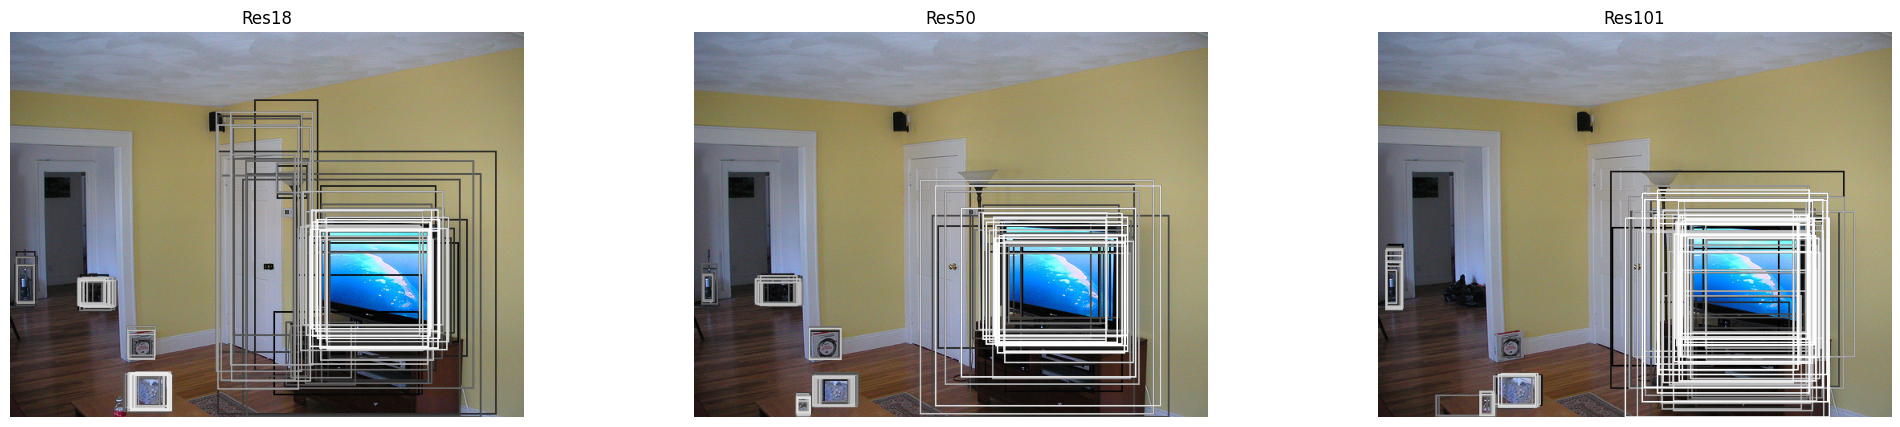

In [16]:
# plot proposals
i = 110
plot_limit = 100
img_path = train_dataset.images[i]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
ori_img = Image.open(img_path).convert('RGBA')

# plot r18 proposals
ax = axes[0]
img = ori_img.copy()
draw = ImageDraw.Draw(img, "RGBA")
boxes = resnet18_proposals[i][:plot_limit, :4].astype(int).copy()
scores = resnet18_proposals[i][:plot_limit, 4]
scores = (scores - scores.min()) / (scores.max() - scores.min())
plotted = 0
for box, score in zip(boxes[:plot_limit][::-1], scores[:plot_limit][::-1]):
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=(0, 0, 0, int((1 - score) * 255)), width=2)
ax.imshow(img)
ax.axis('off')
ax.set_title('Res18')
img.save('rpn_r18_prop.png')

# plot r50 proposals
ax = axes[1]
img = ori_img.copy()
draw = ImageDraw.Draw(img, "RGBA")
boxes = resnet50_proposals[i][:plot_limit, :4].astype(int)
scores = resnet50_proposals[i][:plot_limit, 4]
scores = (scores - scores.min()) / (scores.max() - scores.min())
plotted = 0
for box, score in zip(boxes[:plot_limit][::-1], scores[:plot_limit][::-1]):
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=(0, 0, 0, int((1 - score) * 255)), width=2)
    plotted += 1
    if plotted > plot_limit:
        break
ax.imshow(img)
ax.axis('off')
ax.set_title('Res50')
img.save('rpn_r50_prop.png')

# plot r101 proposals
ax = axes[2]
img = ori_img.copy()
draw = ImageDraw.Draw(img, "RGBA")
boxes = resnet101_proposals[i][:plot_limit, :4].astype(int)
scores = resnet101_proposals[i][:plot_limit, 4]
scores = (scores - scores.min()) / (scores.max() - scores.min())
plotted = 0
for box, score in zip(boxes[:plot_limit][::-1], scores[:plot_limit][::-1]):
    draw.rectangle(((box[0], box[1]), (box[2], box[3])), outline=(0, 0, 0, int((1 - score) * 255)), width=2)
ax.imshow(img)
ax.axis('off')
ax.set_title('Res101')
img.save('rpn_r101_prop.png')

# SIM

In [13]:
crowd_labels, conf_matrix, box_params = generate_synthetic_data(train_dataset, pixel_offset=0, n_annotator=5, annotator_acc_mean=0.5, fixed_box=True)
df = crowd_labels2df(crowd_labels, train_dataset)

<Axes: >

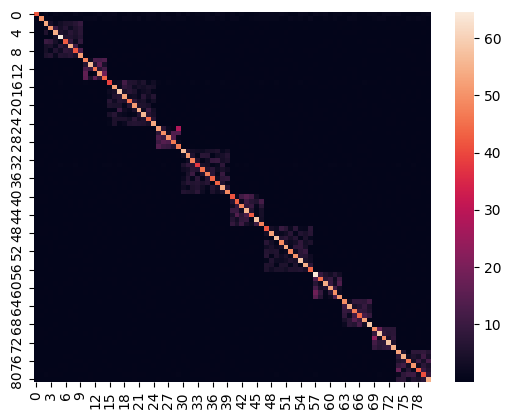

In [14]:
sns.heatmap(conf_matrix[0] * 100)

In [15]:
save_path = '../data/coco_ann5_sim'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'conf_matrix.npy'), conf_matrix)
np.save(os.path.join(save_path, 'box_params.npy'), box_params)

In [16]:
df

,img_path,x1,y1,x2,y2,class_id,annotator_id
0,000000391895.jpg,359,146,471,359,64,0
1,000000391895.jpg,339,22,493,322,0,0
2,000000391895.jpg,471,172,507,220,65,0
3,000000391895.jpg,486,183,516,218,1,0
4,000000391895.jpg,359,146,471,359,3,1
...,...,...,...,...,...,...,...
4236008,000000475546.jpg,329,160,344,190,44,4
4236009,000000475546.jpg,195,267,208,292,44,4
4236010,000000475546.jpg,270,260,385,327,70,4
4236011,000000475546.jpg,474,158,500,227,0,4


In [17]:
df[['x1', 'y1', 'class_id']].min()

x1          0
y1          0
class_id    0
dtype: int64

In [18]:
crowd_labels_df2txt(df, path=os.path.join(save_path, 'noisy_train'))

In [19]:
train_clean_df = clean2df(train_dataset)

In [20]:
train_clean_df

,img_path,x1,y1,x2,y2,class_id
0,000000391895.jpg,359,146,471,359,3
1,000000391895.jpg,339,22,493,322,0
2,000000391895.jpg,471,172,507,220,0
3,000000391895.jpg,486,183,516,218,1
4,000000522418.jpg,382,0,639,474,0
...,...,...,...,...,...,...
849896,000000475546.jpg,329,160,344,190,40
849897,000000475546.jpg,195,267,208,292,41
849898,000000475546.jpg,270,260,385,327,71
849899,000000475546.jpg,474,158,500,227,0


In [21]:
crowd_labels_df2txt(train_clean_df, path=os.path.join(save_path, 'clean_train'))

In [22]:
test_df = clean2df(test_dataset)

In [23]:
test_df

,img_path,x1,y1,x2,y2,class_id
0,000000397133.jpg,217,240,256,298,39
1,000000397133.jpg,1,240,347,427,60
2,000000397133.jpg,388,69,498,347,0
3,000000397133.jpg,135,249,157,278,43
4,000000397133.jpg,31,344,99,384,45
...,...,...,...,...,...,...
36329,000000015335.jpg,160,66,238,151,0
36330,000000015335.jpg,599,422,640,480,41
36331,000000015335.jpg,2,306,47,323,67
36332,000000015335.jpg,362,102,386,130,0


In [24]:
crowd_labels_df2txt(test_df, path=os.path.join(save_path, 'test'))

In [25]:
!touch {' '.join([os.path.join(save_path, 'test', os.path.basename(f) + '.txt') for f in missing_test])}

In [26]:
!touch {' '.join([os.path.join(save_path, 'clean_train', os.path.basename(f) + '.txt') for f in missing_train])}
!touch {' '.join([os.path.join(save_path, 'noisy_train', os.path.basename(f) + '.txt') for f in missing_train])}

# FULL

In [17]:
conf_matrix = generate_dl_conf_matrix(10, vgg16_cm)
rpn_proposals = {i: resnet50_proposals for i in range(10)}

# crowd_labels, conf_matrix, box_params = generate_synthetic_data(train_dataset, pixel_offset=0, n_annotator=10, conf_matrix=conf_matrix, fixed_box=False,
#                                                                 translation_err_mean=(0.1, 0.1), translation_err_std=(0.01, 0.01), 
#                                                                 scale_err_mean=(0.3, 0.3), scale_err_std=(0.05, 0.05))
crowd_labels, conf_matrix, box_params = generate_synthetic_data(train_dataset, pixel_offset=0, n_annotator=10, conf_matrix=conf_matrix, fixed_box=False,
                                                                rpn_proposals=rpn_proposals)
df = crowd_labels2df(crowd_labels, train_dataset)

In [18]:
conf_matrix[0,].sum(axis=1)

array([          1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           

<Axes: >

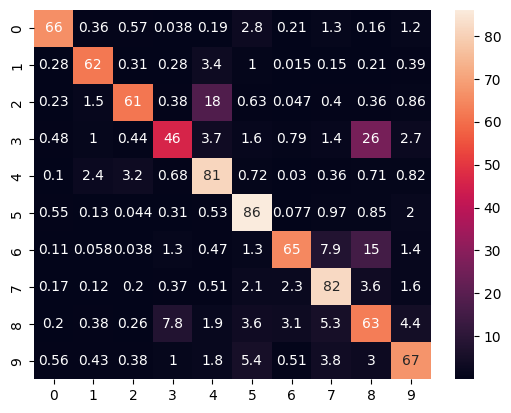

In [19]:
sns.heatmap(conf_matrix[0, :10, :10] * 100, annot=True)

In [22]:
save_path = '../data/coco_ann10_full'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'conf_matrix.npy'), conf_matrix)
np.save(os.path.join(save_path, 'box_params.npy'), box_params)

In [23]:
df

,img_path,x1,y1,x2,y2,class_id,annotator_id
0,000000391895.jpg,343,9,488,273,58,0
1,000000391895.jpg,353,50,452,283,0,0
2,000000391895.jpg,484,188,515,197,72,0
3,000000391895.jpg,486,167,512,217,1,0
4,000000391895.jpg,359,146,471,359,3,1
...,...,...,...,...,...,...,...
8471661,000000475546.jpg,329,160,344,190,8,9
8471662,000000475546.jpg,195,266,213,298,55,9
8471663,000000475546.jpg,270,260,385,327,71,9
8471664,000000475546.jpg,474,158,500,227,0,9


In [24]:
df[['x1', 'y1', 'class_id']].min()

x1          0
y1          0
class_id    0
dtype: int64

In [25]:
df[df['x1'] >= (df['x2'] - 1)]

,img_path,x1,y1,x2,y2,class_id,annotator_id
24738,000000247306.jpg,477,161,478,162,77,0
24766,000000247306.jpg,477,161,478,162,14,1
24794,000000247306.jpg,477,161,478,162,14,2
24850,000000247306.jpg,477,161,478,162,4,4
24905,000000247306.jpg,477,161,478,162,0,6
...,...,...,...,...,...,...,...
8437185,000000485696.jpg,141,385,142,389,0,5
8437199,000000485696.jpg,141,385,142,389,0,6
8437213,000000485696.jpg,141,385,142,389,0,7
8437227,000000485696.jpg,141,385,142,389,59,8


In [26]:
crowd_labels_df2txt(df, path=os.path.join(save_path, 'noisy_train'))

In [27]:
train_clean_df = clean2df(train_dataset)

In [28]:
train_clean_df

,img_path,x1,y1,x2,y2,class_id
0,000000391895.jpg,359,146,471,359,3
1,000000391895.jpg,339,22,493,322,0
2,000000391895.jpg,471,172,507,220,0
3,000000391895.jpg,486,183,516,218,1
4,000000522418.jpg,382,0,639,474,0
...,...,...,...,...,...,...
849896,000000475546.jpg,329,160,344,190,40
849897,000000475546.jpg,195,267,208,292,41
849898,000000475546.jpg,270,260,385,327,71
849899,000000475546.jpg,474,158,500,227,0


In [29]:
crowd_labels_df2txt(train_clean_df, path=os.path.join(save_path, 'clean_train'))

In [30]:
test_df = clean2df(test_dataset)

In [31]:
test_df

,img_path,x1,y1,x2,y2,class_id
0,000000397133.jpg,217,240,256,298,39
1,000000397133.jpg,1,240,347,427,60
2,000000397133.jpg,388,69,498,347,0
3,000000397133.jpg,135,249,157,278,43
4,000000397133.jpg,31,344,99,384,45
...,...,...,...,...,...,...
36329,000000015335.jpg,160,66,238,151,0
36330,000000015335.jpg,599,422,640,480,41
36331,000000015335.jpg,2,306,47,323,67
36332,000000015335.jpg,362,102,386,130,0


In [32]:
crowd_labels_df2txt(test_df, path=os.path.join(save_path, 'test'))

In [33]:
!touch {' '.join([os.path.join(save_path, 'test', os.path.basename(f) + '.txt') for f in missing_test])}

In [34]:
!touch {' '.join([os.path.join(save_path, 'clean_train', os.path.basename(f) + '.txt') for f in missing_train])}
!touch {' '.join([os.path.join(save_path, 'noisy_train', os.path.basename(f) + '.txt') for f in missing_train])}

In [14]:
import itertools
all_colors = list(set(itertools.permutations([0, 0, 0, 128, 128, 128, 255, 255, 255], r=3)))

In [250]:
temp = [i for i in range(len(train_dataset)) if len(train_dataset.get_gt(i)) == 4]

92531


True

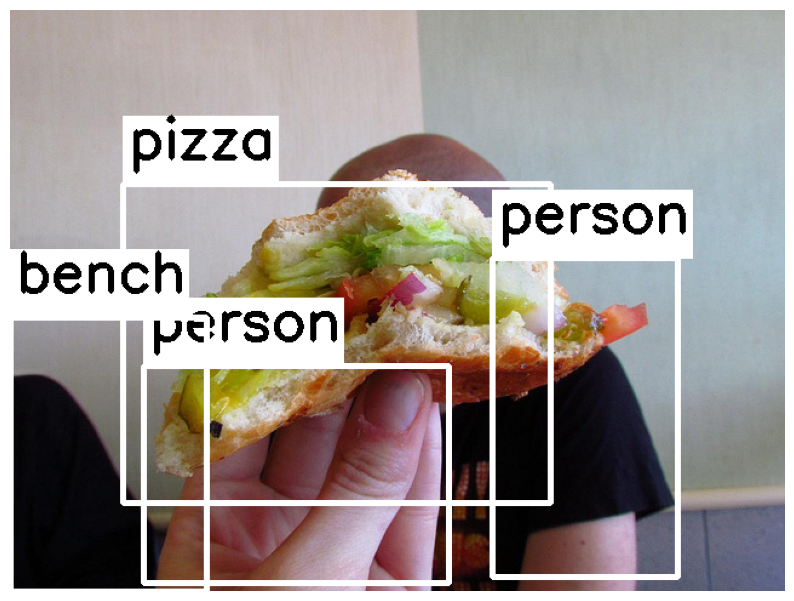

In [393]:
i = np.random.choice(temp)
# i = 97530
i=92531
print(i)
plt.figure(figsize=(10, 8))
img_path = train_dataset.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

n = 10
ann_dir = '../data/coco_ann10_full/noisy_train'
with open(os.path.join(ann_dir, os.path.basename(img_path) + '.txt'), 'r') as f:
    bbox = np.asarray([list(map(int, x.strip().split(','))) for x in f.readlines()], dtype=np.float32)

# plot some annotators
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255,0,255), (255,255,0), (0, 128, 128), (128,0,128), (128,128,0), (128,128,128)]
# bboxes = [[x[:4] for x in y] for y in crowd_labels[i][:10]]
# labels = [[train_dataset.classes[x[4]] for x in y] for y in crowd_labels[i][:10]]
bboxes = [bbox[bbox[:, 5] == k, :4].astype(int) for k in range(n)][3]
labels = [[train_dataset.classes[y + 1] for y in bbox[bbox[:, 5] == k, 4].astype(int)] for k in range(n)][3]
# colors = [[all_colors[int(y)] for y in bbox[bbox[:, 5] == k, 4].astype(int)] for k in range(n)]

# for color, box, label in zip(colors, bboxes, labels):
#     img = bbv.draw_multiple_rectangles(img, box, color, thickness=2)
    # img = bbv.add_multiple_labels(img, label, box, color)
for box, label in zip(bboxes, labels):
    img = bbv.draw_rectangle(img, box, thickness=4)
    img = bbv.add_label(img, label, box, size=1.5, thickness=3)

# bboxes = [x[:4] for x in train_dataset.get_gt(i)]
# labels = [train_dataset.classes[x[4]] for x in train_dataset.get_gt(i)]
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=4)
#     # img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
cv2.imwrite('./example_crowd2.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

# MIX
doesnt make sense that all 25 annotator look through 100k images (as in voc dataset). so we have:
- 20 dedicated annotators labels ~5% of the images (resnet)
- 550 normal annotators labels ~1% of the images (vgg)
- 330 weak annotators labels ~ 0.5% of the images (alexnet)
- 100 bad players labels ~1% of the images (random)

In [35]:
seed = 1234
n_classes = len(train_dataset.classes)
generator = np.random.default_rng(seed=seed)
# expert
exp_conf_matrix = generate_dl_conf_matrix(20, resnet50_cm, seed=seed)
exp_box_params = generate_box_parameters(20, translation_err_mean=(0.05, 0.05), translation_err_std=(0.01, 0.01), 
                                     scale_err_mean=(0.1, 0.1), scale_err_std=(0.05, 0.05), seed=seed)
exp_coverage = generator.uniform(-0.005, 0.005, exp_conf_matrix.shape[0]) + 0.05 # small uniform noise

# normal
norm_conf_matrix = generate_dl_conf_matrix(550, vgg16_cm, seed=seed+1)
norm_box_params = generate_box_parameters(550, translation_err_mean=(0.1, 0.1), translation_err_std=(0.01, 0.01), 
                                     scale_err_mean=(0.3, 0.3), scale_err_std=(0.05, 0.05), seed=seed+1)
norm_coverage = generator.uniform(-0.001, 0.001, norm_conf_matrix.shape[0]) + 0.01

# weak
weak_conf_matrix = generate_dl_conf_matrix(330, alexnet_cm, seed=seed+2)
weak_box_params = generate_box_parameters(330, translation_err_mean=(0.2, 0.2), translation_err_std=(0.05, 0.05), 
                                     scale_err_mean=(0.4, 0.4), scale_err_std=(0.1, 0.1), seed=seed+2)
weak_coverage = generator.uniform(-0.001, 0.001, weak_conf_matrix.shape[0]) + 0.005

# bad
bad_conf_matrix = generator.uniform(size=(100, n_classes, n_classes)) + np.tile(np.eye(n_classes) * 0.5, (100, 1, 1))
bad_conf_matrix = bad_conf_matrix / bad_conf_matrix.sum(axis=-1, keepdims=True)
bad_box_params = generate_box_parameters(100, translation_err_mean=(0.3, 0.3), translation_err_std=(0.2, 0.2), 
                                     scale_err_mean=(0.5, 0.5), scale_err_std=(0.2, 0.2), seed=seed+3)
bad_coverage = generator.uniform(-0.001, 0.001, bad_conf_matrix.shape[0]) + 0.01

conf_matrix = np.concatenate((exp_conf_matrix, norm_conf_matrix, weak_conf_matrix, bad_conf_matrix), axis=0)
box_params = np.concatenate((exp_box_params, norm_box_params, weak_box_params, bad_box_params), axis=0)
ann_coverage = np.concatenate((exp_coverage, norm_coverage, weak_coverage, bad_coverage), axis=0)

In [36]:
rpn_proposals = {}
for i in range(20):
    rpn_proposals[i] = resnet101_proposals
for i in range(20, 570):
    rpn_proposals[i] = resnet50_proposals
for i in range(570, 1000):
    rpn_proposals[i] = resnet18_proposals
assert len(rpn_proposals) == conf_matrix.shape[0]

In [37]:
conf_matrix.shape, box_params.shape, ann_coverage.shape

((1000, 81, 81), (1000, 4, 2), (1000,))

<BarContainer object of 81 artists>

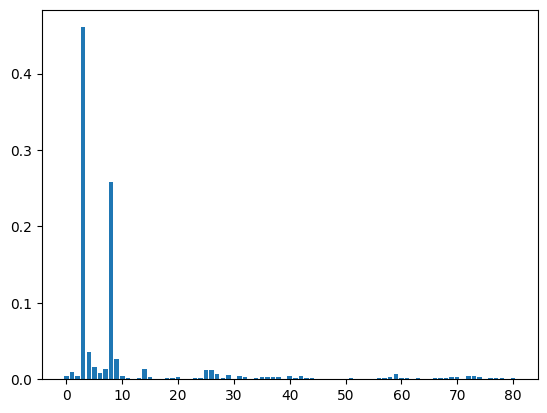

In [38]:
plt.bar(range(81), conf_matrix[100, 3])

In [39]:
(ann_coverage > 0).all()

True

In [40]:
conf_matrix.sum(axis=-1)

array([[          1,           1,           1, ...,           1,           1,           1],
       [          1,           1,           1, ...,           1,           1,           1],
       [          1,           1,           1, ...,           1,           1,           1],
       ...,
       [          1,           1,           1, ...,           1,           1,           1],
       [          1,           1,           1, ...,           1,           1,           1],
       [          1,           1,           1, ...,           1,           1,           1]])

<Axes: >

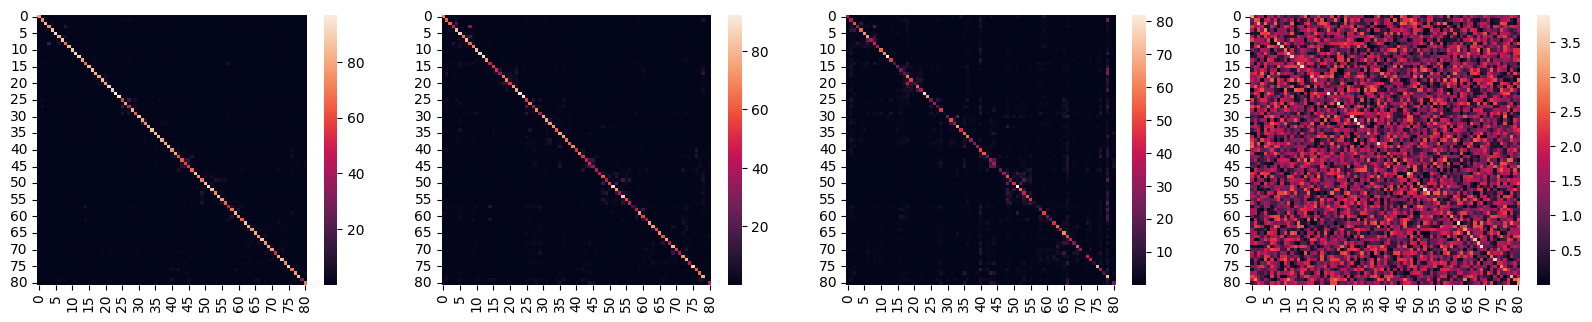

In [41]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 3.5))
sns.heatmap(conf_matrix[0] * 100, ax=ax1)
sns.heatmap(conf_matrix[100] * 100, ax=ax2)
sns.heatmap(conf_matrix[-250] * 100, ax=ax3)
sns.heatmap(conf_matrix[-1] * 100, ax=ax4)

In [42]:
save_path = '../data/coco_ann1000_mix_disjoint'
os.makedirs(save_path, exist_ok=True)
np.save(os.path.join(save_path, 'conf_matrix.npy'), conf_matrix)
np.save(os.path.join(save_path, 'box_params.npy'), box_params)

In [50]:
# crowd_labels, conf_matrix, box_params = generate_synthetic_data(train_dataset, pixel_offset=0, conf_matrix=conf_matrix, box_params=box_params, 
#                                                                 fixed_box=False, annotator_coverage=ann_coverage)
crowd_labels, conf_matrix, box_params = generate_synthetic_data(train_dataset, pixel_offset=0, conf_matrix=conf_matrix, rpn_proposals=rpn_proposals, 
                                                                fixed_box=False, annotator_coverage=ann_coverage)


In [51]:
len(train_dataset), len(crowd_labels)

(118287, 118287)

In [52]:
crowd_labels[0]

[[],
 [],
 [],
 [],
 [],
 [],
 [[355, 207, 474, 346, 37],
  [336, 9, 485, 341, 1],
  [472, 177, 519, 225, 50],
  [484, 188, 513, 219, 2]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [[359, 146, 471, 359, 4],
  [339, 22, 493, 322, 1],
  [471, 172, 507, 220, 1],
  [486, 183, 516, 218, 25]],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [

(-0.5, 479.5, 639.5, -0.5)

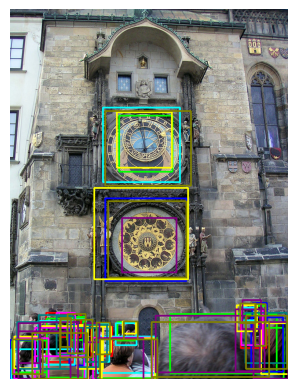

In [56]:
i=1001
img_path = train_dataset.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# plot annotators
ci = 0
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255,0,255), (255,255,0), (0, 128, 128), (128,0,128), (128,128,0), (128,128,128)]
bboxes = [[x[:4] for x in y] for y in crowd_labels[i]]
labels = [[train_dataset.classes[x[4]] for x in y] for y in crowd_labels[i]]

for box, label in zip(bboxes, labels):
    if len(box):
        img = bbv.draw_multiple_rectangles(img, box, colors[ci], thickness=2)
        ci += 1
        if ci >= len(colors):
            break
    # img = bbv.add_multiple_labels(img, label, box, color)
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)


plt.imshow(img)
plt.axis('off')
# print(crowd_labels[i])

In [54]:
df = crowd_labels2df(crowd_labels, train_dataset)

In [55]:
df

,img_path,x1,y1,x2,y2,class_id,annotator_id
0,000000391895.jpg,355,207,474,346,36,6
1,000000391895.jpg,336,9,485,341,0,6
2,000000391895.jpg,472,177,519,225,49,6
3,000000391895.jpg,484,188,513,219,1,6
4,000000391895.jpg,359,146,471,359,3,79
...,...,...,...,...,...,...,...
7739989,000000475546.jpg,248,177,253,185,1,968
7739990,000000475546.jpg,316,126,383,192,2,968
7739991,000000475546.jpg,195,260,216,296,38,968
7739992,000000475546.jpg,282,296,365,330,77,968


In [57]:
df[['x1', 'y1', 'class_id']].min()

x1          0
y1          0
class_id    0
dtype: int64

In [58]:
df[df['x1'] >= (df['x2'] - 1)]

,img_path,x1,y1,x2,y2,class_id,annotator_id
22622,000000247306.jpg,477,161,478,162,14,2
22650,000000247306.jpg,477,161,478,162,14,115
22706,000000247306.jpg,477,161,478,162,14,320
22790,000000247306.jpg,477,161,478,162,16,639
22874,000000247306.jpg,477,161,478,162,52,997
...,...,...,...,...,...,...,...
7708388,000000485696.jpg,141,385,142,389,0,403
7708402,000000485696.jpg,141,385,142,389,0,428
7708416,000000485696.jpg,141,385,142,389,0,523
7708430,000000485696.jpg,141,385,142,389,59,752


In [59]:
crowd_labels_df2txt(df, path=os.path.join(save_path, 'noisy_train'))

In [60]:
train_clean_df = clean2df(train_dataset)

In [61]:
train_clean_df

,img_path,x1,y1,x2,y2,class_id
0,000000391895.jpg,359,146,471,359,3
1,000000391895.jpg,339,22,493,322,0
2,000000391895.jpg,471,172,507,220,0
3,000000391895.jpg,486,183,516,218,1
4,000000522418.jpg,382,0,639,474,0
...,...,...,...,...,...,...
849896,000000475546.jpg,329,160,344,190,40
849897,000000475546.jpg,195,267,208,292,41
849898,000000475546.jpg,270,260,385,327,71
849899,000000475546.jpg,474,158,500,227,0


In [62]:
# crowd_labels_df2txt(train_clean_df, path=os.path.join(save_path, 'clean_train'))

In [63]:
test_df = clean2df(test_dataset)

In [64]:
test_df

,img_path,x1,y1,x2,y2,class_id
0,000000397133.jpg,217,240,256,298,39
1,000000397133.jpg,1,240,347,427,60
2,000000397133.jpg,388,69,498,347,0
3,000000397133.jpg,135,249,157,278,43
4,000000397133.jpg,31,344,99,384,45
...,...,...,...,...,...,...
36329,000000015335.jpg,160,66,238,151,0
36330,000000015335.jpg,599,422,640,480,41
36331,000000015335.jpg,2,306,47,323,67
36332,000000015335.jpg,362,102,386,130,0


In [65]:
# crowd_labels_df2txt(test_df, path=os.path.join(save_path, 'test'))

In [66]:
# !touch {' '.join([os.path.join(save_path, 'test', os.path.basename(f) + '.txt') for f in missing_test])}

In [67]:
# !touch {' '.join([os.path.join(save_path, 'clean_train', os.path.basename(f) + '.txt') for f in missing_train])}
!touch {' '.join([os.path.join(save_path, 'noisy_train', os.path.basename(f) + '.txt') for f in missing_train])}